**Loan Approval Syatem**

Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

Datset

In [4]:
df = pd.read_csv('Loan-Approval-Prediction.csv')


Finding and Filling Missing Values 

In [5]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
for col in ["Gender","Married","Dependents","Self_Employed","Credit_History"]:
    if df[col].mode().empty:
        df[col] = df[col].fillna("unknown")
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

In [7]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [8]:
df["LoanAmount"] = df["LoanAmount"].fillna(0)
df["Loan_Amount_Term"] = df["Loan_Amount_Term"].fillna(360)
df.isna().sum() 

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Train Test Split

In [9]:
x = df.drop(["Loan_Status","Loan_ID"],axis=1)
y = df["Loan_Status"].map({"N":0, "Y":1})

In [10]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [11]:
#Identifing column types
num_cols = x.select_dtypes(include=["int64","float64"]).columns
cat_cols = x.select_dtypes(include=["object"]).columns

Create ML Pipeline

In [12]:
preprocessor = ColumnTransformer([("num",StandardScaler(),num_cols),
                                  ("cat",OneHotEncoder(handle_unknown="ignore"),cat_cols)])
pipeline = Pipeline([("preprocess", preprocessor),
                    ("model",LogisticRegression(max_iter=1000))])

Cross-Validation

In [13]:
cv_scores = cross_val_score(pipeline,x,y,cv=5)

print("CV Scores:",cv_scores)
print("Average CV Accuracy:",cv_scores.mean())

CV Scores: [0.81300813 0.7804878  0.7804878  0.85365854 0.81967213]
Average CV Accuracy: 0.809462881514061


Hyperparameter Tuned

In [14]:
param_grid =[
    { "model" : [LogisticRegression(max_iter=1000)],
               "model__C" : [0.1,1,10]},
    {"model" : [RandomForestClassifier()],
     "model__n_estimators" : [100,200],
     "model__max_depth" : [3,5,None]}
    ]

grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(x_train,y_train)

print("Best Parameters:",grid.best_params_)
best_model = grid.best_estimator_
print("Best CV Score:",grid.best_score_)

Best Parameters: {'model': LogisticRegression(max_iter=1000), 'model__C': 0.1}
Best CV Score: 0.8145949288806431


Final Evaluation

Final Accuracy: 0.7886178861788617
Confusion Matrix:
 [[18 25]
 [ 1 79]]


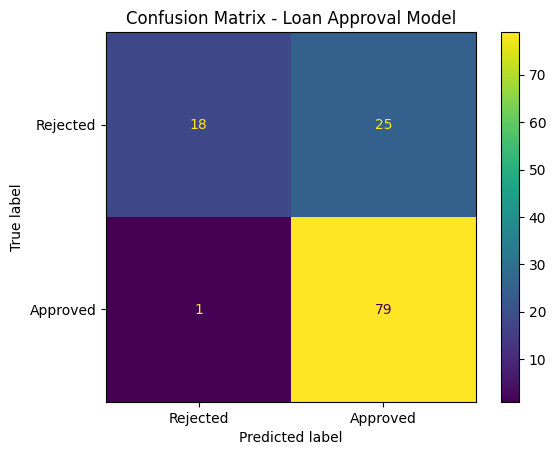

In [15]:
y_pred = best_model.predict(x_test)

acc = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)

print("Final Accuracy:",acc)
print("Confusion Matrix:\n",cm)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Rejected", "Approved"])
disp.plot()

plt.title("Confusion Matrix - Loan Approval Model")
plt.show()

New Predict Loan Approval

Approval Probability: 0.3273312934682929
Rejection Probability: 0.6726687065317071
Loan Prediction: Rejected ❌


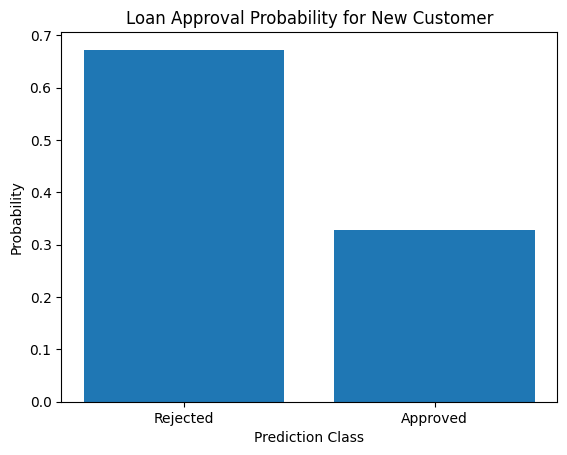

In [16]:
import pandas as pd

new_customer = pd.DataFrame({
    "Gender": ["Male"],
    "Married": ["Yes"],
    "Dependents": ["0"],
    "Education": ["Graduate"],
    "Self_Employed": ["No"],
    "ApplicantIncome": [75000],
    "CoapplicantIncome": [30000],
    "LoanAmount": [200],
    "Loan_Amount_Term": [360],
    "Credit_History": [1.0],
    "Property_Area": ["Urban"]
})

prob = best_model.predict_proba(new_customer)[0]

print("Approval Probability:", prob[1])
print("Rejection Probability:", prob[0])

# Predict loan approval
prediction = best_model.predict(new_customer)

# Convert result to readable output
result = "Approved ✅" if prediction[0] == 1 else "Rejected ❌"

print("Loan Prediction:", result)

labels = ["Rejected", "Approved"]

plt.figure()
plt.bar(labels, prob)
plt.title("Loan Approval Probability for New Customer")
plt.ylabel("Probability")
plt.xlabel("Prediction Class")
plt.show()

ROC Curve Visualization

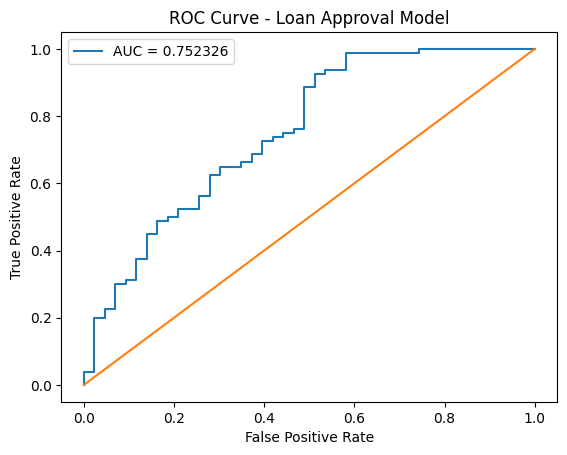

In [17]:
#Probability for test set
y_prob = best_model.predict_proba(x_test)[:,1]

fpr,tpr,_= roc_curve(y_test,y_prob)
roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:2f}")
plt.plot([0,1],[0,1]) #diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Loan Approval Model")
plt.legend()
plt.show()